In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [2]:
df_raw = pd.read_csv("../data.csv")
df = df_raw.copy()

# Drop first column, which I think was created incorrectly.
df = df.iloc[:, 1:]

# 99% of real-world text has a Flesch score between 0 and 100 but it is technically possible to go higher or lower
df["op_flesch_reading_ease"] = df["op_flesch_reading_ease"].clip(0, 100)
df["comment_flesch_reading_ease"] = df["comment_flesch_reading_ease"].clip(0, 150)

# time from OP
df["comment_time_after_op"] = df["comment_created"] - df["op_created"]
# df = df.loc[df["comment_time_after_op"] < 60 * 60 * 24]

# Drop comments and posts that didn't get any attention (so, nothing to measure)
df = df[df["op_score"] >= 3]
df = df[df["op_word_count"] >= 5]
df = df[(df["comment_score"] < 1) | (df["comment_score"] > 1)]
df = df[df["comment_word_count"] >= 10]

df["op_flair"] = df["op_flair"].map({
    "Asshole": "yta",
    "Everyone Sucks": "esh",
    "No A-holes here": "nah",
    "Not enough info": "info",
    "Not the A-hole": "nta"
})


# Drop comments with no judgements
df = df.dropna(subset=["comment_judgement"])
df = df.loc[df["comment_judgement"] != "info"]

# some parsing problems
max_age = 100
min_age = 13
over_max_age_idx = df["op_age"] > max_age
under_min_age_idx = df["op_age"] < min_age
df.loc[over_max_age_idx, "op_age"] = None
df.loc[over_max_age_idx, "op_gender"] = None
df.loc[under_min_age_idx, "op_age"] = None
df.loc[under_min_age_idx, "op_gender"] = None

# Create a special dataframe with one row per OP
df_ops = df.drop_duplicates(subset="op_permalink")
df_ops = df_ops.reset_index(drop=True)
df_ops = df_ops.loc[:,~df_ops.columns.str.startswith("comment_")]

df

,op_ah_judgement_ratio,op_created,op_flair,op_flesch_reading_ease,op_age,op_gender,op_permalink,op_score,op_sentiment,op_upvote_ratio,op_word_count,comment_created,comment_flesch_reading_ease,comment_judgement,comment_permalink,comment_score,comment_sentiment,comment_word_count,comment_time_after_op
0,0.322581,1599142530,nah,72.09,NaN,NaN,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,141,-0.9301,0.89,171,1599142736,82.95,nah,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,487,0.9416,207,206
3,0.322581,1599142530,nah,72.09,NaN,NaN,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,141,-0.9301,0.89,171,1599144417,75.61,nah,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,45,0.2871,164,1887
6,0.322581,1599142530,nah,72.09,NaN,NaN,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,141,-0.9301,0.89,171,1599231805,68.94,nah,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,3,-0.4797,55,89275
8,0.322581,1599142530,nah,72.09,NaN,NaN,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,141,-0.9301,0.89,171,1599150542,87.82,nta,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,10,-0.1630,62,8012
11,0.322581,1599142530,nah,72.09,NaN,NaN,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,141,-0.9301,0.89,171,1599151240,88.74,nta,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,11,0.0000,24,8710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585635,0.410448,1642777851,nta,75.13,NaN,NaN,/r/AmItheAsshole/comments/s9cvlg/aita_for_not_...,886,0.9897,0.91,344,1642778747,78.89,yta,/r/AmItheAsshole/comments/s9cvlg/aita_for_not_...,-1,-0.9028,106,896
585649,0.410448,1642777851,nta,75.13,NaN,NaN,/r/AmItheAsshole/comments/s9cvlg/aita_for_not_...,886,0.9897,0.91,344,1642781080,117.16,yta,/r/AmItheAsshole/comments/s9cvlg/aita_for_not_...,0,0.0000,10,3229
585790,0.410448,1642777851,nta,75.13,NaN,NaN,/r/AmItheAsshole/comments/s9cvlg/aita_for_not_...,886,0.9897,0.91,344,1642779976,55.61,yta,/r/AmItheAsshole/comments/s9cvlg/aita_for_not_...,-2,-0.8794,99,2125
585791,0.410448,1642777851,nta,75.13,NaN,NaN,/r/AmItheAsshole/comments/s9cvlg/aita_for_not_...,886,0.9897,0.91,344,1642780077,75.71,yta,/r/AmItheAsshole/comments/s9cvlg/aita_for_not_...,-2,0.7003,25,2226


In [3]:
df_ops

,op_ah_judgement_ratio,op_created,op_flair,op_flesch_reading_ease,op_age,op_gender,op_permalink,op_score,op_sentiment,op_upvote_ratio,op_word_count
0,0.322581,1599142530,nah,72.09,NaN,NaN,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,141,-0.9301,0.89,171
1,0.225806,1628281972,yta,88.77,NaN,NaN,/r/AmItheAsshole/comments/ozexwy/aita_for_call...,205,-0.7025,0.94,163
2,0.641509,1618927573,nta,81.12,NaN,NaN,/r/AmItheAsshole/comments/mur37i/aita_for_not_...,6380,-0.9896,0.96,373
3,0.620000,1642535395,esh,74.02,30.0,m,/r/AmItheAsshole/comments/s763xo/aita_for_refu...,62,-0.9958,0.89,562
4,0.320513,1662154569,nta,76.15,NaN,NaN,/r/AmItheAsshole/comments/x4d5uz/aita_for_aski...,583,0.9867,0.91,370
...,...,...,...,...,...,...,...,...,...,...,...
4937,0.339450,1602813681,nah,30.51,35.0,m,/r/AmItheAsshole/comments/jc12u5/aita_for_yell...,1878,-0.9020,0.96,517
4938,0.492537,1669563822,yta,77.87,NaN,NaN,/r/AmItheAsshole/comments/z64c40/aita_for_givi...,2399,0.3447,0.89,355
4939,0.523810,1647808761,nah,76.05,NaN,NaN,/r/AmItheAsshole/comments/tiub6w/aita_for_tell...,78,0.8372,0.85,450
4940,0.446154,1648319451,esh,79.43,NaN,NaN,/r/AmItheAsshole/comments/tozq8c/aita_for_read...,321,0.1890,0.93,281


<AxesSubplot: xlabel='op_ah_judgement_ratio', ylabel='Count'>

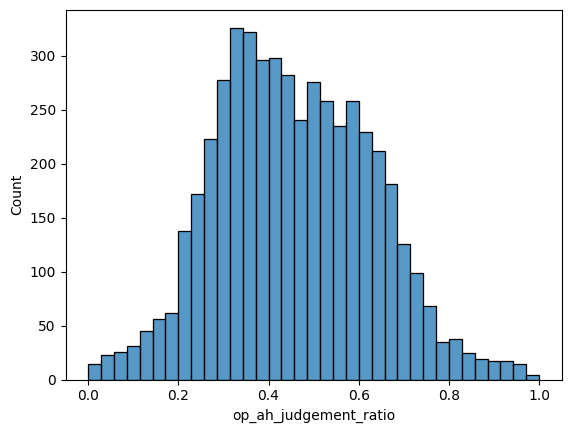

In [4]:
sns.histplot(df_ops, x="op_ah_judgement_ratio")

<AxesSubplot: xlabel='op_flesch_reading_ease', ylabel='Count'>

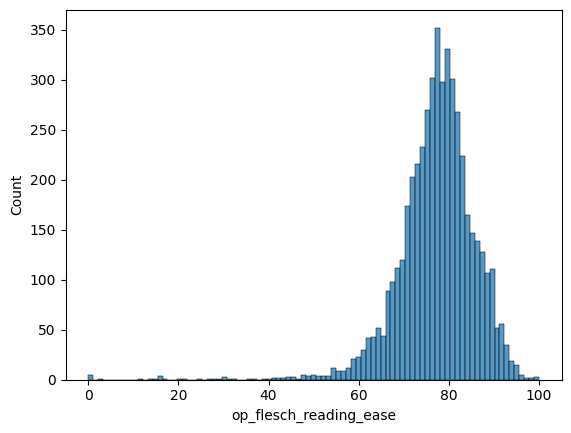

In [5]:
sns.histplot(df_ops, x="op_flesch_reading_ease")

<AxesSubplot: xlabel='op_age', ylabel='Count'>

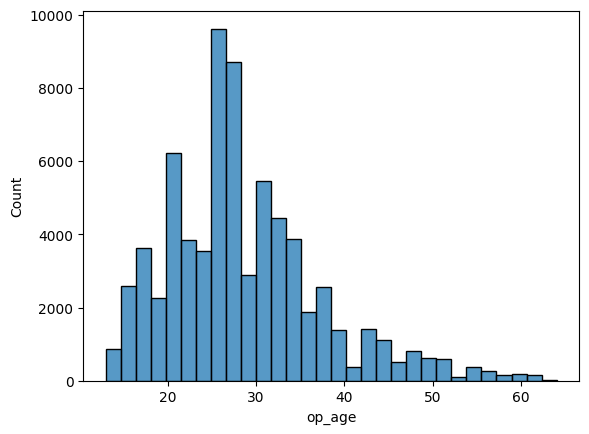

In [6]:
sns.histplot(df, x="op_age", bins=30)

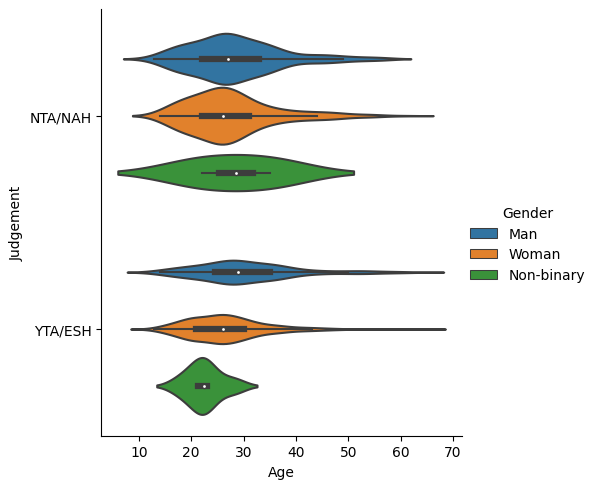

In [7]:
df_violin = df_ops.copy()
df_violin["op_flair"] = df_violin["op_flair"].map({
    "nah": "NTA/NAH",
    "nta": "NTA/NAH",
    "yta": "YTA/ESH",
    "esh": "YTA/ESH"
})
df_violin["op_gender"] = df_violin["op_gender"].map({
    "m": "Man",
    "f": "Woman",
    "nb": "Non-binary"
})
df_violin = df_violin.rename(columns={"op_gender": "Gender", "op_flair": "Judgement", "op_age": "Age"})
sns.catplot(data=df_violin, x="Age", y="Judgement", hue="Gender", kind="violin")

<AxesSubplot: xlabel='op_score', ylabel='Count'>

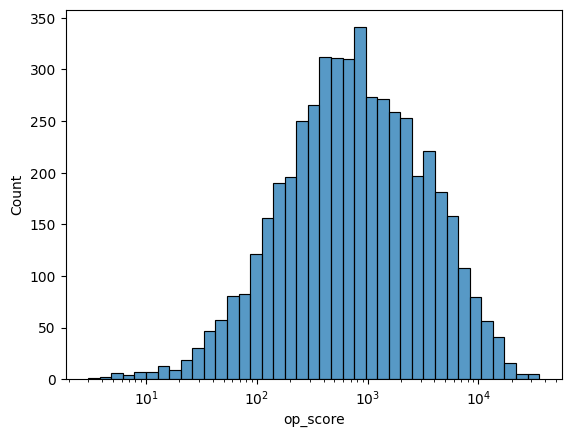

In [8]:
sns.histplot(data=df_ops["op_score"], log_scale=True)

<AxesSubplot: xlabel='op_upvote_ratio', ylabel='Count'>

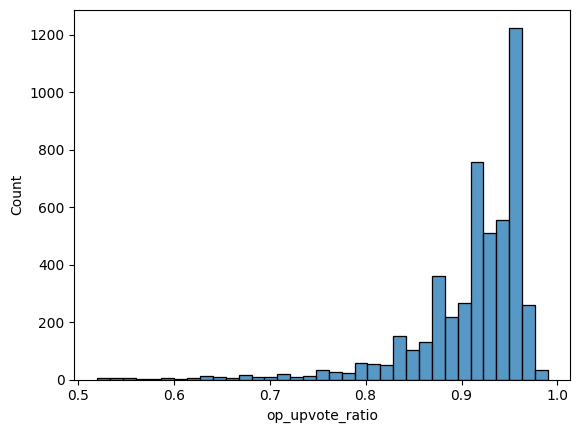

In [9]:
sns.histplot(df_ops, x="op_upvote_ratio", bins=35)

<AxesSubplot: xlabel='op_word_count', ylabel='Count'>

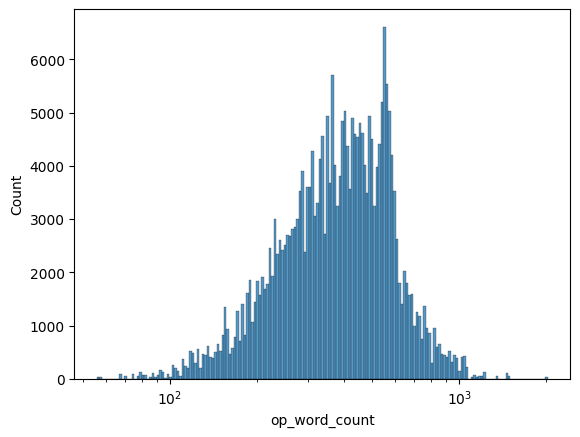

In [10]:
sns.histplot(df, x="op_word_count", log_scale=True)

<AxesSubplot: xlabel='comment_flesch_reading_ease', ylabel='Count'>

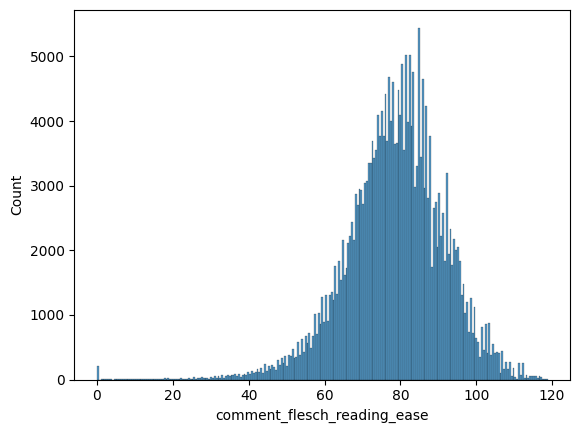

In [11]:
sns.histplot(df["comment_flesch_reading_ease"])

<AxesSubplot: xlabel='comment_sentiment', ylabel='Count'>

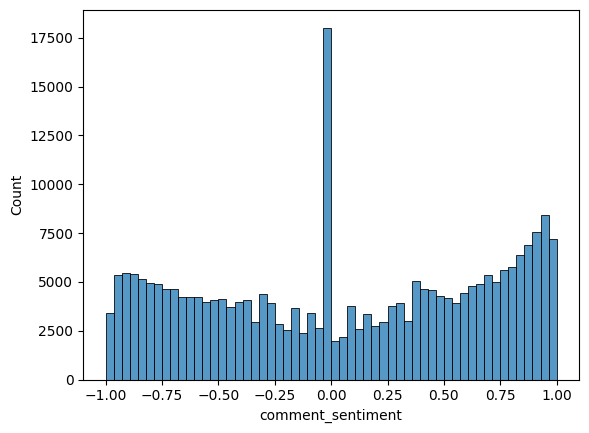

In [12]:
sns.histplot(df["comment_sentiment"])

<AxesSubplot: xlabel='comment_word_count', ylabel='Count'>

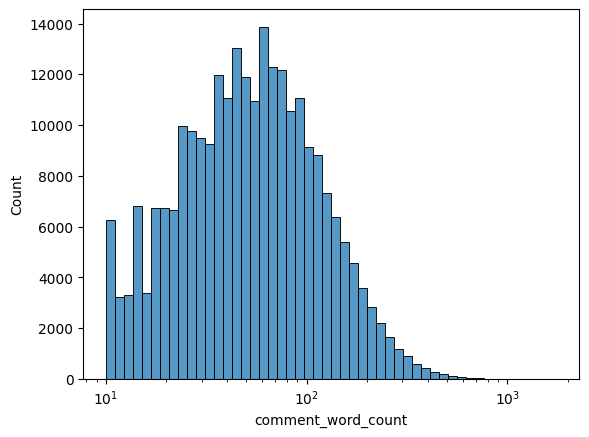

In [13]:
sns.histplot(df, x="comment_word_count", log_scale=True, bins=50)

<AxesSubplot: xlabel='comment_word_count', ylabel='comment_flesch_reading_ease'>

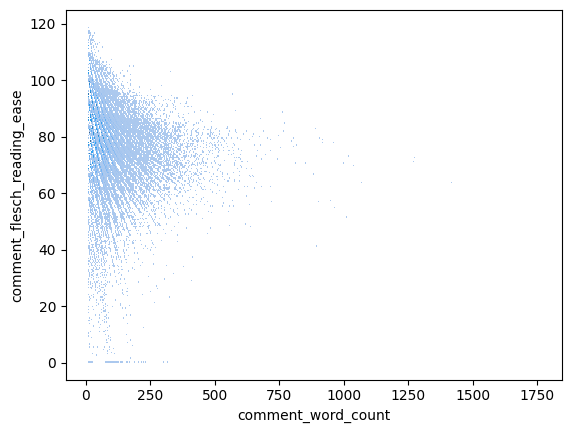

In [14]:
sns.histplot(data=df, x="comment_word_count", y="comment_flesch_reading_ease")

<AxesSubplot: xlabel='comment_time_after_op', ylabel='Count'>

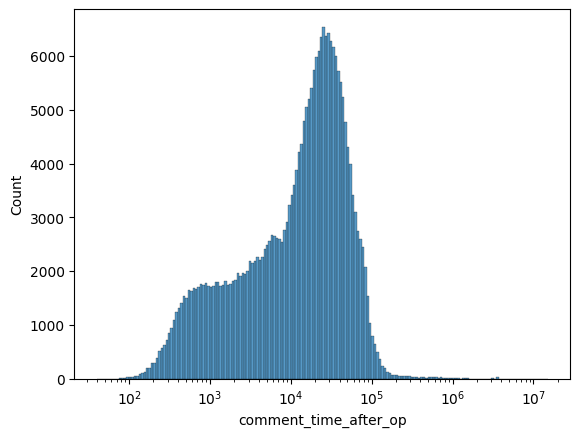

In [15]:
sns.histplot(data=df, x="comment_time_after_op", log_scale=True)

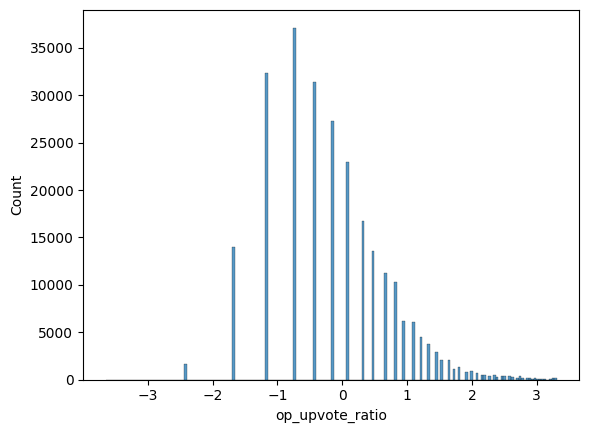

In [16]:
def uvr_transform(x):
    return np.log(-x + 1)

uvr = uvr_transform(df["op_upvote_ratio"])
uvr_ops = uvr_transform(df_ops["op_upvote_ratio"])
sns.histplot((uvr - uvr_ops.mean()) / uvr_ops.std())
plt.show()

In [17]:
maxs = df.groupby("op_permalink")["comment_score"].max()
mins = df.groupby("op_permalink")["comment_score"].min()

relative_comment_scores = df.apply(lambda row: (row["comment_score"] - mins[row["op_permalink"]]) / (maxs[row["op_permalink"]] - mins[row["op_permalink"]] + 1e-6), axis=1)
relative_comment_scores = np.log(relative_comment_scores + 1e-6)

In [18]:
relative_comment_scores

0         9.979711e-07
3        -2.268674e+00
6        -4.003230e+00
8        -3.427890e+00
11       -3.367267e+00
              ...     
585635   -3.476066e+00
585649   -3.188392e+00
585790   -3.881515e+00
585791   -3.881515e+00
585793   -1.381551e+01
Length: 256350, dtype: float64

<AxesSubplot: ylabel='Count'>

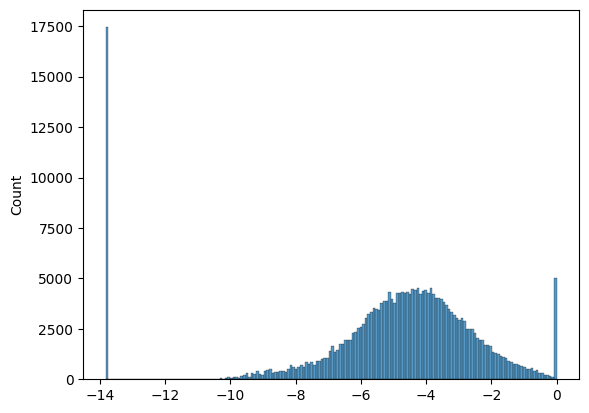

In [19]:
sns.histplot(relative_comment_scores)

<AxesSubplot: ylabel='Count'>

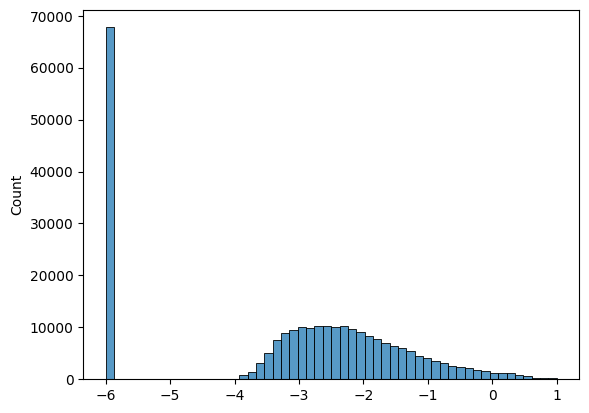

In [20]:
ratios = df["comment_score"] / df["op_score"]
ratios = ratios.clip(0, 10)
ratios = np.log10(ratios + 1e-6)
#ratios = (ratios - ratios.mean()) / ratios.std()
sns.histplot(ratios)

In [21]:
pd.options.display.float_format = '{:20,.4f}'.format

pp = pd.DataFrame()

pp["op_ah_judgement_ratio"] = df["op_ah_judgement_ratio"] # (df["op_ah_judgement_ratio"] - df_ops["op_ah_judgement_ratio"].mean()) / df_ops["op_ah_judgement_ratio"].std()
pp["op_age"] = df["op_age"] # (df["op_age"] - df_ops["op_age"].mean()) / df_ops["op_age"].std()
pp["op_flesch_reading_ease"] = df["op_flesch_reading_ease"] #(df["op_flesch_reading_ease"] - df_ops["op_flesch_reading_ease"].mean()) / df_ops["op_flesch_reading_ease"].std()

pp["op_upvote_ratio"] = uvr # (uvr - uvr_ops.mean()) / uvr_ops.std()
pp["op_word_count"] = df["op_word_count"] # (df["op_word_count"] - df_ops["op_word_count"].mean()) / df_ops["op_word_count"].std()

gender_data = pd.get_dummies(df["op_gender"], prefix="op_gender")
pp["op_gender_f"] = gender_data["op_gender_f"]
pp["op_gender_m"] = gender_data["op_gender_m"]
pp["op_gender_nb"] = gender_data["op_gender_nb"]

flair_data = pd.get_dummies(df["op_flair"], prefix="op_flair")
pp["op_flair_yta"] = flair_data["op_flair_yta"]
pp["op_flair_esh"] = flair_data["op_flair_esh"]
pp["op_flair_nta"] = flair_data["op_flair_nta"]
pp["op_flair_nah"] = flair_data["op_flair_nah"]
pp["op_flair_info"] = flair_data["op_flair_info"]

judgement_data = pd.get_dummies(df["comment_judgement"], prefix="comment_judgement")
pp["comment_judgement_yta"] = judgement_data["comment_judgement_yta"]
pp["comment_judgement_nta"] = judgement_data["comment_judgement_nta"]
pp["comment_judgement_esh"] = judgement_data["comment_judgement_esh"]
pp["comment_judgement_nah"] = judgement_data["comment_judgement_nah"]


pp["comment_flesch_reading_ease"] = df["comment_flesch_reading_ease"] # - df["comment_flesch_reading_ease"].mean()) / df["comment_flesch_reading_ease"].std()
pp["comment_sentiment"] = df["comment_sentiment"] #- df["comment_sentiment"].mean()) / df["comment_sentiment"].std()
pp["comment_time_after_op"] = df["comment_time_after_op"]
pp["comment_time_after_op"] = pp["comment_time_after_op"] # - pp["comment_time_after_op"].mean()) / pp["comment_time_after_op"].std()
pp["comment_to_op_score_ratio"] = ratios # pd.cut(ratios, np.linspace(ratios.min(), ratios.max(), 10), include_lowest=True).map(str)

pp["comment_relative_score"] = (relative_comment_scores - relative_comment_scores.mean()) / relative_comment_scores.std()

pp

,op_ah_judgement_ratio,op_age,op_flesch_reading_ease,op_upvote_ratio,op_word_count,op_gender_f,op_gender_m,op_gender_nb,op_flair_yta,op_flair_esh,...,op_flair_info,comment_judgement_yta,comment_judgement_nta,comment_judgement_esh,comment_judgement_nah,comment_flesch_reading_ease,comment_sentiment,comment_time_after_op,comment_to_op_score_ratio,comment_relative_score
0,0.3226,NaN,72.0900,-2.2073,171,0,0,0,0,0,...,0,0,0,0,1,82.9500,0.9416,206,0.5383,1.7013
3,0.3226,NaN,72.0900,-2.2073,171,0,0,0,0,0,...,0,0,0,0,1,75.6100,0.2871,1887,-0.4960,0.9369
6,0.3226,NaN,72.0900,-2.2073,171,0,0,0,0,0,...,0,0,0,0,1,68.9400,-0.4797,89275,-1.6721,0.3525
8,0.3226,NaN,72.0900,-2.2073,171,0,0,0,0,0,...,0,0,1,0,0,87.8200,-0.1630,8012,-1.1492,0.5464
11,0.3226,NaN,72.0900,-2.2073,171,0,0,0,0,0,...,0,0,1,0,0,88.7400,0.0000,8710,-1.1078,0.5668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585635,0.4104,NaN,75.1300,-2.4079,344,0,0,0,0,0,...,0,1,0,0,0,78.8900,-0.9028,896,-6.0000,0.5301
585649,0.4104,NaN,75.1300,-2.4079,344,0,0,0,0,0,...,0,1,0,0,0,117.1600,0.0000,3229,-6.0000,0.6270
585790,0.4104,NaN,75.1300,-2.4079,344,0,0,0,0,0,...,0,1,0,0,0,55.6100,-0.8794,2125,-6.0000,0.3935
585791,0.4104,NaN,75.1300,-2.4079,344,0,0,0,0,0,...,0,1,0,0,0,75.7100,0.7003,2226,-6.0000,0.3935


In [22]:
len(pp.groupby("op_ah_judgement_ratio"))

2003

In [23]:
for k in pp.keys():
    print(f"{k}\t{pp[k].isnull().values.any()}")

op_ah_judgement_ratio	False
op_age	True
op_flesch_reading_ease	False
op_upvote_ratio	False
op_word_count	False
op_gender_f	False
op_gender_m	False
op_gender_nb	False
op_flair_yta	False
op_flair_esh	False
op_flair_nta	False
op_flair_nah	False
op_flair_info	False
comment_judgement_yta	False
comment_judgement_nta	False
comment_judgement_esh	False
comment_judgement_nah	False
comment_flesch_reading_ease	False
comment_sentiment	False
comment_time_after_op	False
comment_to_op_score_ratio	False
comment_relative_score	False


In [24]:
def gender_mim(X, model):
    preds = {}
    genders = {"f", "m", "nb", None}
    for gender in genders:
        hypothetical_X = X.copy()
        if gender:
            hypothetical_X[f"op_gender_{gender}"] = 1
        for other_gender in genders.difference({gender}):
            if other_gender:
                hypothetical_X[f"op_gender_{other_gender}"] = 0
        preds[gender] = model.predict(hypothetical_X)

    y_mim = np.zeros_like(preds["f"])
    for gender in genders:
        if gender:
            p_gender = X[f"op_gender_{gender}"].sum() / len(X)
        else:
            p_gender = (len(X) - X["op_gender_f"].sum() - X["op_gender_m"].sum() - X["op_gender_nb"].sum()) / len(X)

        y_mim += preds[gender] * p_gender

    return y_mim

In [25]:
pp.iloc[16]

op_ah_judgement_ratio                       0.3226
op_age                                         NaN
op_flesch_reading_ease                     72.0900
op_upvote_ratio                            -2.2073
op_word_count                             171.0000
op_gender_f                                 0.0000
op_gender_m                                 0.0000
op_gender_nb                                0.0000
op_flair_yta                                0.0000
op_flair_esh                                0.0000
op_flair_nta                                0.0000
op_flair_nah                                1.0000
op_flair_info                               0.0000
comment_judgement_yta                       0.0000
comment_judgement_nta                       0.0000
comment_judgement_esh                       0.0000
comment_judgement_nah                       1.0000
comment_flesch_reading_ease                71.7800
comment_sentiment                          -0.2186
comment_time_after_op          

In [27]:
X = pp.drop(["comment_to_op_score_ratio", "comment_relative_score"], axis=1)
y = pp["comment_relative_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=690)

prot_attrs = ["op_gender_m", "op_gender_f", "op_gender_nb", "op_age"]
X_train_no_prot_attr = X_train.drop(prot_attrs, axis=1)
X_test_no_prot_attr = X_test.drop(prot_attrs, axis=1)

f_index_train = X_train["op_gender_f"] == 1
m_index_train = X_train["op_gender_m"] == 1
nb_index_train = X_train["op_gender_nb"] == 1
none_index_train = (X_train["op_gender_f"] == 0) & (X_train["op_gender_m"] == 0) & (X_train["op_gender_nb"] == 0)

f_index = X_test["op_gender_f"] == 1
m_index = X_test["op_gender_m"] == 1
nb_index = X_test["op_gender_nb"] == 1
none_index = (X_test["op_gender_f"] == 0) & (X_test["op_gender_m"] == 0) & (X_test["op_gender_nb"] == 0)

yta_index_train = (X_train["op_flair_yta"] == 1) | (X_train["op_flair_esh"] == 1)
nta_index_train = (X_train["op_flair_nta"] == 1) | (X_train["op_flair_nah"] == 1)

yta_index = (X_test["op_flair_yta"] == 1) | (X_test["op_flair_esh"] == 1)
nta_index = (X_test["op_flair_nta"] == 1) | (X_test["op_flair_nah"] == 1)

teen_index_train = X_train["op_age"] <= 18
young_adult_index_train = (X_train["op_age"] >= 19) & (X_train["op_age"] <= 25)
adult_index_train = (X_train["op_age"] >= 26) & (X_train["op_age"] <= 55)
old_adult_index_train = X_train["op_age"] >= 55
unknown_age_index_train = X_train["op_age"].isna()

teen_index = X_test["op_age"] <= 18
young_adult_index = (X_test["op_age"] >= 19) & (X_test["op_age"] <= 25)
adult_index = (X_test["op_age"] >= 26) & (X_test["op_age"] <= 55)
old_adult_index = X_test["op_age"] >= 55
unknown_age_index = X_test["op_age"].isna()

def compute_scores(y_test, y_pred, y_train, y_pred_train):
    print(" - Training R2 score:", r2_score(y_train, y_pred_train))
    print("     - For f:", r2_score(y_train[f_index_train], y_pred_train[f_index_train]))
    print("     - For m:", r2_score(y_train[m_index_train], y_pred_train[m_index_train]))
    print("     - For nb:", r2_score(y_train[nb_index_train], y_pred_train[nb_index_train]))
    print("     - For unspecified gender:", r2_score(y_train[none_index_train], y_pred_train[none_index_train]))
    print(f"     - For teens: {r2_score(y_train[teen_index_train], y_pred_train[teen_index_train])}")
    print(f"     - For young adults: {r2_score(y_train[young_adult_index_train], y_pred_train[young_adult_index_train])}")
    print(f"     - For adults: {r2_score(y_train[adult_index_train], y_pred_train[adult_index_train])}")
    print(f"     - For old adults: {r2_score(y_train[old_adult_index_train], y_pred_train[old_adult_index_train])}")
    print(f"     - For unspecified age: {r2_score(y_train[unknown_age_index_train], y_pred_train[unknown_age_index_train])}")
    for judgement, index in (("yta/esh", yta_index_train), ("nta/nah", nta_index_train)):
        print(f" - Training average {judgement} score: {y_pred_train[index].mean()} vs. real {y_train[index].mean()}")
        for gender, gender_index in (("m", m_index_train), ("f", f_index_train), ("nb", nb_index_train), ("none", none_index_train)):
            print(f"     - average {judgement} score for {gender}: {y_pred_train[index & gender_index].mean()} vs. real {y_train[index & gender_index].mean()}")
    for judgement, index in (("yta/esh", yta_index_train), ("nta/nah", nta_index_train)):
        print(f" - Training average {judgement} score: {y_pred_train[index].mean()} vs. real {y_train[index].mean()}")
        for age, age_index in (("teen", teen_index_train), ("ya", young_adult_index_train), ("a", adult_index_train), ("oa", old_adult_index_train), ("none", unknown_age_index_train)):
            print(f"     - average {judgement} score for {age}: {y_pred_train[index & age_index].mean()} vs. real {y_train[index & age_index].mean()}")
    print(" - Testing R2 score:", r2_score(y_test, y_pred))
    print("     - For f:", r2_score(y_test[f_index], y_pred[f_index]))
    print("     - For m:", r2_score(y_test[m_index], y_pred[m_index]))
    print("     - For nb:", r2_score(y_test[nb_index], y_pred[nb_index]))
    print("     - For unspecified gender:", r2_score(y_test[none_index], y_pred[none_index]))
    print(f"     - For teens: {r2_score(y_test[teen_index], y_pred[teen_index])}")
    print(f"     - For young adults: {r2_score(y_test[young_adult_index], y_pred[young_adult_index])}")
    print(f"     - For adults: {r2_score(y_test[adult_index], y_pred[adult_index])}")
    print(f"     - For old adults: {r2_score(y_test[old_adult_index], y_pred[old_adult_index])}")
    print(f"     - For unspecified age: {r2_score(y_test[unknown_age_index], y_pred[unknown_age_index])}")
    for judgement, index in (("yta/esh", yta_index), ("nta/nah", nta_index)):
        print(f"- Testing average {judgement} score: {y_pred[index].mean()} vs. real {y_test[index].mean()}")
        for gender, gender_index in (("m", m_index), ("f", f_index), ("nb", nb_index), ("none", none_index)):
            print(f"     - average {judgement} score for {gender}: {y_pred[index & gender_index].mean():.4f}")
    for judgement, index in (("yta/esh", yta_index), ("nta/nah", nta_index)):
        print(f" - Training average {judgement} score: {y_pred[index].mean()} vs. real {y_test[index].mean()}")
        for age, age_index in (("teen", teen_index), ("ya", young_adult_index), ("a", adult_index), ("oa", old_adult_index), ("none", unknown_age_index)):
            print(f"     - average {judgement} score for {age}: {y_pred[index & age_index].mean():.4f}")

    print(f"""
{y_pred[yta_index & teen_index].mean():.4f}/{y_pred[nta_index & teen_index].mean():.4f} &
{y_pred[yta_index & young_adult_index].mean():.4f}/{y_pred[nta_index & young_adult_index].mean():.4f} &
{y_pred[yta_index & adult_index].mean():.4f}/{y_pred[nta_index & adult_index].mean():.4f} &
{y_pred[yta_index & old_adult_index].mean():.4f}/{y_pred[nta_index & old_adult_index].mean():.4f} &
{y_pred[yta_index & unknown_age_index].mean():.4f}/{y_pred[nta_index & unknown_age_index].mean():.4f} &
""")

    print()

def evaluate_model(model):
    if type(model) is not HistGradientBoostingRegressor:
        my_X_train = X_train.copy()
        my_X_test = X_test.copy()
        my_X_train["op_age"] = my_X_train["op_age"].fillna(X["op_age"].mean())
        my_X_test["op_age"] = my_X_test["op_age"].fillna(X["op_age"].mean())
        my_X_train_no_prot_attr = X_train_no_prot_attr
        my_X_test_no_prot_attr = X_test_no_prot_attr
    else:
        my_X_train = X_train
        my_X_test = X_test
        my_X_train_no_prot_attr = X_train_no_prot_attr
        my_X_test_no_prot_attr = X_test_no_prot_attr

    print("Raw model:")
    model.fit(my_X_train, y_train)
    y_pred = model.predict(my_X_test)
    y_pred_train = model.predict(my_X_train)
    compute_scores(y_test, y_pred, y_train, y_pred_train)

    print("MIM model:")
    y_mim = gender_mim(my_X_test, model)
    y_mim_train = gender_mim(my_X_train, model)
    compute_scores(y_test, y_mim, y_train, y_mim_train)

    print("Drop protected attributes:")
    model.fit(my_X_train_no_prot_attr, y_train)
    y_pred = model.predict(my_X_test_no_prot_attr)
    y_pred_train = model.predict(my_X_train_no_prot_attr)
    compute_scores(y_test, y_pred, y_train, y_pred_train)

In [28]:
evaluate_model(HistGradientBoostingRegressor(learning_rate=0.3, random_state=690, max_leaf_nodes=90, max_iter=140))

Raw model:
 - Training R2 score: 0.6263036442392511
     - For f: 0.631878140472616
     - For m: 0.6875403270064685
     - For nb: 0.501160079552365
     - For unspecified gender: 0.6145927255867306
     - For teens: 0.6833854927506164
     - For young adults: 0.6034547937079696
     - For adults: 0.6709235004023695
     - For old adults: 0.7910336529534066
     - For unspecified age: 0.6145927255867306
 - Training average yta/esh score: -0.004910014752781431 vs. real -0.003517179867850941
     - average yta/esh score for m: -0.06237070071109482 vs. real -0.0696307839896952
     - average yta/esh score for f: 0.06361030706452728 vs. real 0.06953004626371913
     - average yta/esh score for nb: 0.12821563152018575 vs. real 0.17298186012447334
     - average yta/esh score for none: -0.009849247837266725 vs. real -0.00810145131389883
 - Training average nta/nah score: 0.03519805554649216 vs. real 0.03577702230537258
     - average nta/nah score for m: -0.01995919645855246 vs. real -0.009

In [29]:
import shap

model = HistGradientBoostingRegressor(learning_rate=0.3, random_state=690, max_leaf_nodes=90, max_iter=140)
model.fit(X_train, y_train)

X_test_sample = X_test.sample(1000); X_test_sample
y_pred_sample = model.predict(X_test_sample)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_sample)
np.abs(shap_values.sum(1) + explainer.expected_value - y_pred_sample).max()

1.0658141036401503e-14

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


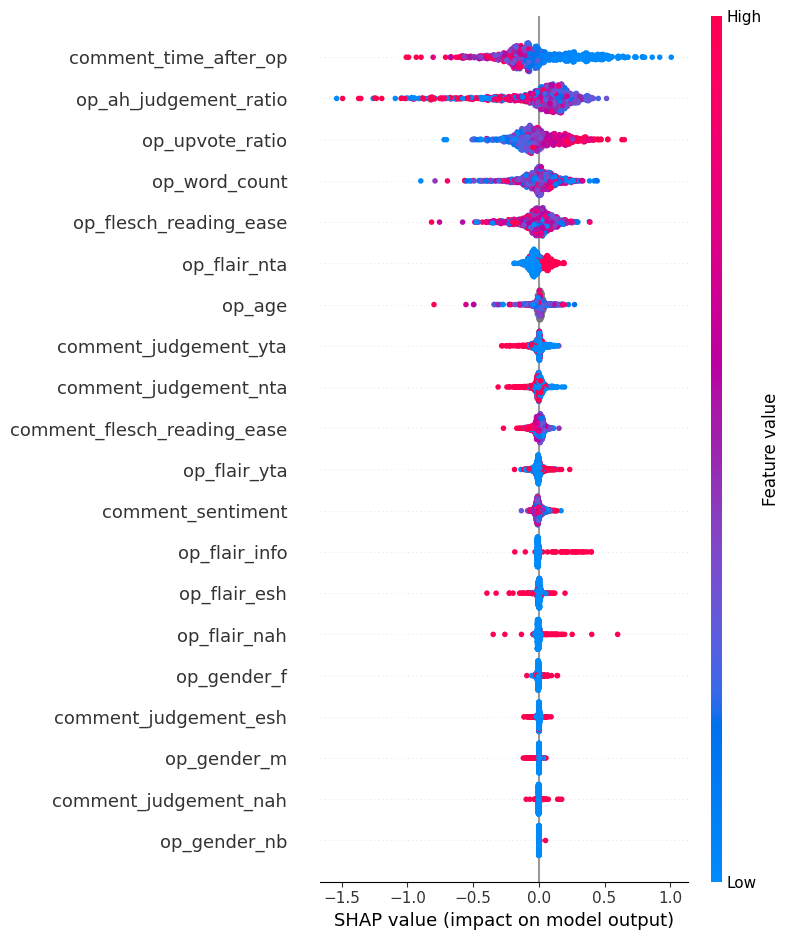

In [30]:
shap.summary_plot(shap_values, X_test_sample)

In [31]:
model

HistGradientBoostingRegressor(learning_rate=0.3, max_iter=140,
                              max_leaf_nodes=90, random_state=690)

In [32]:
orig_X_train = df.loc[X_train.index].sort_index(); orig_X_train

,op_ah_judgement_ratio,op_created,op_flair,op_flesch_reading_ease,op_age,op_gender,op_permalink,op_score,op_sentiment,op_upvote_ratio,op_word_count,comment_created,comment_flesch_reading_ease,comment_judgement,comment_permalink,comment_score,comment_sentiment,comment_word_count,comment_time_after_op
0,0.3226,1599142530,nah,72.0900,NaN,NaN,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,141,-0.9301,0.8900,171,1599142736,82.9500,nah,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,487,0.9416,207,206
3,0.3226,1599142530,nah,72.0900,NaN,NaN,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,141,-0.9301,0.8900,171,1599144417,75.6100,nah,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,45,0.2871,164,1887
6,0.3226,1599142530,nah,72.0900,NaN,NaN,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,141,-0.9301,0.8900,171,1599231805,68.9400,nah,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,3,-0.4797,55,89275
8,0.3226,1599142530,nah,72.0900,NaN,NaN,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,141,-0.9301,0.8900,171,1599150542,87.8200,nta,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,10,-0.1630,62,8012
11,0.3226,1599142530,nah,72.0900,NaN,NaN,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,141,-0.9301,0.8900,171,1599151240,88.7400,nta,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,11,0.0000,24,8710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585635,0.4104,1642777851,nta,75.1300,NaN,NaN,/r/AmItheAsshole/comments/s9cvlg/aita_for_not_...,886,0.9897,0.9100,344,1642778747,78.8900,yta,/r/AmItheAsshole/comments/s9cvlg/aita_for_not_...,-1,-0.9028,106,896
585649,0.4104,1642777851,nta,75.1300,NaN,NaN,/r/AmItheAsshole/comments/s9cvlg/aita_for_not_...,886,0.9897,0.9100,344,1642781080,117.1600,yta,/r/AmItheAsshole/comments/s9cvlg/aita_for_not_...,0,0.0000,10,3229
585790,0.4104,1642777851,nta,75.1300,NaN,NaN,/r/AmItheAsshole/comments/s9cvlg/aita_for_not_...,886,0.9897,0.9100,344,1642779976,55.6100,yta,/r/AmItheAsshole/comments/s9cvlg/aita_for_not_...,-2,-0.8794,99,2125
585791,0.4104,1642777851,nta,75.1300,NaN,NaN,/r/AmItheAsshole/comments/s9cvlg/aita_for_not_...,886,0.9897,0.9100,344,1642780077,75.7100,yta,/r/AmItheAsshole/comments/s9cvlg/aita_for_not_...,-2,0.7003,25,2226


In [33]:
orig_X_test = df.loc[X_test.index].sort_index(); orig_X_test

,op_ah_judgement_ratio,op_created,op_flair,op_flesch_reading_ease,op_age,op_gender,op_permalink,op_score,op_sentiment,op_upvote_ratio,op_word_count,comment_created,comment_flesch_reading_ease,comment_judgement,comment_permalink,comment_score,comment_sentiment,comment_word_count,comment_time_after_op
16,0.3226,1599142530,nah,72.0900,NaN,NaN,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,141,-0.9301,0.8900,171,1599143394,96.5200,nta,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,22,0.4939,68,864
22,0.3226,1599142530,nah,72.0900,NaN,NaN,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,141,-0.9301,0.8900,171,1599164674,84.6800,nah,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,2,0.0943,13,22144
24,0.3226,1599142530,nah,72.0900,NaN,NaN,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,141,-0.9301,0.8900,171,1599154916,105.9600,nta,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,2,0.3875,23,12386
26,0.3226,1599142530,nah,72.0900,NaN,NaN,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,141,-0.9301,0.8900,171,1599142779,91.1100,yta,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,-3,0.9264,84,249
27,0.3226,1599142530,nah,72.0900,NaN,NaN,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,141,-0.9301,0.8900,171,1599164700,71.7800,nah,/r/AmItheAsshole/comments/ilu770/aita_for_bein...,0,-0.2186,148,22170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585528,0.4462,1648319451,esh,79.4300,NaN,NaN,/r/AmItheAsshole/comments/tozq8c/aita_for_read...,321,0.1890,0.9300,281,1648322774,94.6600,yta,/r/AmItheAsshole/comments/tozq8c/aita_for_read...,4,0.0000,21,3323
585586,0.4104,1642777851,nta,75.1300,NaN,NaN,/r/AmItheAsshole/comments/s9cvlg/aita_for_not_...,886,0.9897,0.9100,344,1642778889,89.4500,nta,/r/AmItheAsshole/comments/s9cvlg/aita_for_not_...,93,0.6124,25,1038
585602,0.4104,1642777851,nta,75.1300,NaN,NaN,/r/AmItheAsshole/comments/s9cvlg/aita_for_not_...,886,0.9897,0.9100,344,1642779135,86.7400,nah,/r/AmItheAsshole/comments/s9cvlg/aita_for_not_...,8,0.4795,55,1284
585605,0.4104,1642777851,nta,75.1300,NaN,NaN,/r/AmItheAsshole/comments/s9cvlg/aita_for_not_...,886,0.9897,0.9100,344,1642778906,84.4700,yta,/r/AmItheAsshole/comments/s9cvlg/aita_for_not_...,16,0.8555,62,1055


In [34]:
model

HistGradientBoostingRegressor(learning_rate=0.3, max_iter=140,
                              max_leaf_nodes=90, random_state=690)

In [35]:
i = 0

actuals = []
comment_judgements = []
op_judgements = []

for name, group in orig_X_train.groupby("op_permalink"):
    idx = group.index
    metadata = df.loc[idx].iloc[0]
    in_data = pp.loc[idx]
    X_temp = in_data.drop(["comment_relative_score", "comment_to_op_score_ratio"], axis=1)
    y_temp = in_data["comment_relative_score"]
    predictions = model.predict(X_temp)
    predictions = pd.Series(predictions)
    
    comment = in_data.iloc[np.argmax(predictions)]
    
    actuals.append(metadata["op_flair"])
    
    if comment["comment_judgement_yta"]:
        comment_judgements.append("yta")
        op_judgements.append("ytaesh")
    elif comment["comment_judgement_esh"]:
        comment_judgements.append("esh")
        op_judgements.append("ytaesh")
    elif comment["comment_judgement_nta"]:
        comment_judgements.append("nta")
        op_judgements.append("ntanah")
    elif comment["comment_judgement_nah"]:
        comment_judgements.append("nah")
        op_judgements.append("ntanah")

    
    i += 1
    if i % 50 == 0:
        pass # break

actuals = np.array(actuals)
comment_judgements = np.array(comment_judgements)
op_judgements = np.array(op_judgements)
op_actuals = np.array(list(map(lambda x: "ytaesh" if x in {"yta", "esh"} else "ntanah", actuals)))

In [36]:
(op_actuals == op_judgements).mean()

0.8016595830803481

In [37]:
(actuals == comment_judgements).mean()

0.7077514673143088

In [38]:
from sklearn.metrics import cohen_kappa_score

print(cohen_kappa_score(op_actuals, op_judgements))

0.6020784505796849


In [39]:
print(cohen_kappa_score(actuals, comment_judgements))

0.5902821089973707
